In [88]:
import os, sys, copy, time, math, random, numbers, itertools, tqdm, importlib, re
from PIL import Image
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Set the environment variable
# os.environ["TORCH_USE_CUDA_DSA"] = "1"
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rasterio
import torch
import yaml

from sklearn import metrics
from skimage import transform as trans
from pathlib import Path
from collections.abc import Sequence
from datetime import datetime, timedelta
from scipy.ndimage import rotate
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# The code cell is used to add the src directory to the Python path, making 
# it possible to import modules from that directory. 

module_path = os.path.abspath(os.path.join('../src'))
sys.path.insert(0, module_path)

In [90]:
from custom_dataset import CropData
from models.unet import Unet
from model_compiler import ModelCompiler
from custom_loss_functions import *
from utils import *

In [76]:
!pwd

/shishir/multi-temporal-crop-classification-baseline/notebooks


In [6]:
# The code cell loads a configuration file (default_config.yaml) using the YAML library and stores the 
# configuration data in the config dictionary. Then, it processes the global_stats section of the config 
# dictionary by expanding the lists for each stats based on the number of available time points. 
# As you can see we decided to generate a single set of normalization statistics and use it to 
# normalize all the time-points.

yaml_config_path = "/shishir/multi-temporal-crop-classification-baseline/config/default_config.yaml"  # replace this path to your own config file.
num_time_points = 1  # Change this number accordingly if you use a dataset with a different temporal length.

with open(yaml_config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.SafeLoader)

# Perform multiplication and concatenation for each key in global_stats
for key, value in config['global_stats'].items():
    config['global_stats'][key] = value * num_time_points

In [7]:
config['src_dir']

'/shishir/All_Datasets/NASA-Crop-Classification/non-temporal-6-channel-data/training_chips/'

In [8]:
# OPTIONAL
# pretty-print the config dictionary

import pprint
# pprint.pprint(config, width=100, compact=True)

## FILTER OUT WHEAT IMAGES

In [9]:
training_sample="/shishir/All_Datasets/NASA-Crop-Classification/non-temporal-6-channel-data/training_chips/"
# Get all files in the directory
images_list=[]
masks_list=[]

files_masks = os.listdir(training_sample+"/masks/")
files_images = os.listdir(training_sample+"/images/")

# Print the list of files
print("Files in directory:")
for file in files_images:
    images_list.append(file)
    # print(file)

print("Files in directory:")
for file in files_masks:
    masks_list.append(file)
    # print(file)

ln_images=len(images_list)
ln_masks=len(masks_list)
### filter out the non common images
if ln_masks<ln_images:
    images_list=[i for i in images_list if i in masks_list]

elif ln_masks>ln_images:
    masks_list=[i for i in masks_list if i in images_list]
        
mask_path="/shishir/All_Datasets/NASA-Crop-Classification/non-temporal-6-channel-data/training_chips/masks"

mask_data_size=50176

from tqdm import tqdm

mask_freq_fil=[]
masks_list_fil=[]
threshold=1.5
for msk in tqdm(masks_list):
    with rasterio.open(mask_path+"/"+msk) as mask:
        mask_data = mask.read()
        # print(np.unique(img_data.flatten()))
        # print(
        if np.unique(mask_data.flatten())[-1]==0:
            # print(msk)
            continue
        # print(msk,"####")  
        
        unique_values, counts = np.unique(mask_data.flatten(), return_counts=True)
        percentages = (counts[1] / mask_data_size) * 100

        # print(percentages)

        if percentages>threshold:

            masks_list_fil.append(msk) 
            mask_freq_fil.append(percentages)



Files in directory:
Files in directory:


  0%|                                                                                                                               | 0/9249 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9249/9249 [00:32<00:00, 286.96it/s]


## PLOTTING IMAGES OF GIVEN WHEAT PROPORTION TO VERIFY

In [10]:
masks_list_fil_1=masks_list_fil.copy()
mask_freq_tuple=[(img,freq) for img,freq in zip(masks_list_fil_1,mask_freq_fil)]

In [ ]:
mask_freq_tuple.sort(key=lambda x:x[1],reverse=True)

In [ ]:
mask_freq_tuple[4000]

In [ ]:
# len(masks_list_fil)
len(mask_freq_tuple)

In [ ]:
masks_list_fil[20]

In [ ]:
import random

up=len(masks_list_fil)-1
random_integer = random.randint(0, up)
img_name=masks_list_fil[20]
# masks_list_fil[random_integer]

temp_img_path="/shishir/All_Datasets/NASA-Crop-Classification/non-temporal-6-channel-data/validation_chips/images/"+img_name
temp_mask_path="/shishir/All_Datasets/NASA-Crop-Classification/non-temporal-6-channel-data/validation_chips/masks/"+img_name

with rasterio.open(temp_img_path) as img:
    img_data = img.read()
img.close()

with rasterio.open(temp_mask_path) as img:
    mask_data = img.read()
img.close()

# #mask_data[mask_data == 8] = 255
# #mask_data[mask_data != 255] = 0
mask_data = np.transpose(mask_data, (1, 2, 0))

# mask_data = np.squeeze(mask_data)
# # Create an empty array to store the RGB mask
# rgb_mask = np.zeros((*mask_data.shape, 3), dtype=np.uint8)

# # Convert each pixel value in the mask to RGB using the provided RGB values
# for pixel_value, rgb_value in crop_rgb_values.items():
#     # Find pixels with the current value and assign the corresponding RGB value
#     rgb_mask[mask_data == pixel_value] = rgb_value


t1_img= img_data[0:6]


for img_ind, t_img in enumerate([t1_img]):
    print(f"for T{img_ind+1}_IMAGE:shape{t_img.shape}")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

for img_ind, t_img in enumerate([t1_img,mask_data]):
    
    # Choose bands for Red, Green, and Blue channels
    # Here, we select the Red, Green, and Blue bands respectively
    if img_ind == 0:
        red_band = t_img[2]
        green_band = t_img[1]
        blue_band = t_img[0]

        # Combine bands to create the RGB image
        rgb_image = np.dstack((red_band, green_band, blue_band))*1.0
        rgb_image = rgb_image.astype(np.float16)

        # Normalize each channel separately
        normalized_image = (rgb_image/rgb_image.max())*255
        normalized_image = np.uint8(normalized_image)
        
        pil_image = Image.fromarray(normalized_image)
        pil_image.save(f"output_image_{img_ind}.jpg")

        # Visualize RGB image
        axes[img_ind].imshow(normalized_image)
        axes[img_ind].axis("off")
        axes[img_ind].set_title(f'T{img_ind+1} Image')
    else:
        axes[img_ind].imshow(mask_data,cmap="gray")
        axes[img_ind].axis("off")
        axes[img_ind].set_title("Mask")
        # axes[img_ind].legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))
    

In [ ]:
plt.imshow(mask_data,cmap="gray")

In [392]:
np.unique(mask_data.flatten())

array([0, 1], dtype=uint8)

In [393]:
unique_values, counts = np.unique(mask_data.flatten(), return_counts=True)
percentages = (counts[1] / mask_data_size) * 100

In [394]:
counts,unique_values,percentages

(array([49588,   588]), array([0, 1], dtype=uint8), 1.171875)

## ANALYSIS FOR WHEAT THRESHOLD DETERMINATION

In [8]:
directory="/shishir/All_Datasets/NASA-Crop-Classification/non-temporal-6-channel-data/training_chips/masks/"
files = os.listdir(directory)

In [9]:
files=[i for i in files if "t1_" in i]  

In [10]:

pixels_freq = []

# Assuming 'files' is the list of file names and 'directory' is the path to the directory
for i in tqdm(files):
    with rasterio.open(directory + i) as img:
        mask_data = img.read()
        total_pixels = mask_data.size  # Total number of pixels in the image
        unique_values, counts = np.unique(mask_data.flatten(), return_counts=True)
        
        # Calculate percentage of each value
        percentages = (counts / total_pixels) * 100
        
        # Append unique values and their percentages to the list
        pixels_freq.append([unique_values, percentages])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3083/3083 [00:07<00:00, 421.66it/s]


In [237]:
wheat_prop=[i[1][0] for i in pixels_freq]

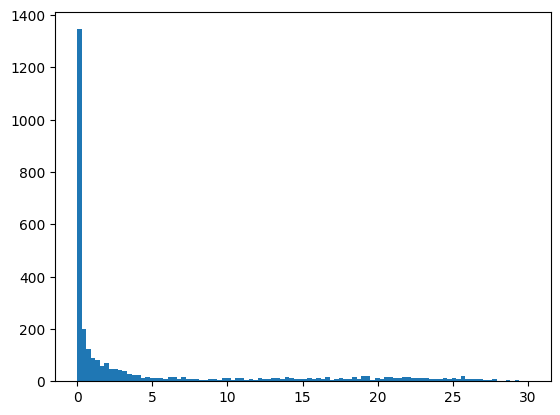

In [238]:
plt.hist(wheat_prop,bins=100);

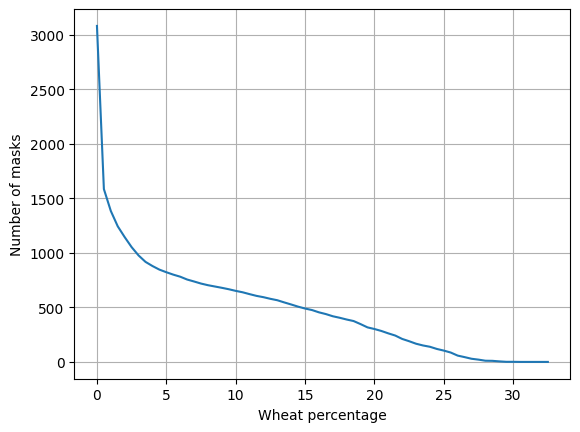

In [267]:
plt.plot(dict_bins.keys(),dict_bins.values())
plt.xlabel("Wheat percentage")
plt.ylabel("Number of masks")
plt.grid()

In [275]:
wheat_prop_sorted[800]

5.502630739795919

In [261]:
bins=np.arange(0.0,33.0,0.5)
dict_bins={}

for i in bins:
    dict_bins[i]=0
    
kys=dict_bins.keys()
wheat_prop_sorted=np.sort(wheat_prop)[::-1]

for i in wheat_prop_sorted:
    for k in kys:
        if i>=k:
            # print(i,
            dict_bins[k]=dict_bins.get(k,0)+1
        else:
            break
            

### Steps for training and finetuning

In [11]:
# STEP 1-1: Data Preparation and Loading
# This code cell reads the input dataset for training, pre-processes it, and creates a 'torch.utils.Dataset' 
# object to be used in the model training process. It utilizes the 'CropData' class from the custom module 
# (CropData.py) to achieve this.

train_dataset = CropData(src_dir=config["src_dir"],
                         usage="train",
                         dataset_name="",
                         filtered_images=masks_list_fil,
                         csv_path=config["train_csv_path"],
                         apply_normalization=config["apply_normalization"],
                         normal_strategy=config["normal_strategy"],
                         stat_procedure=config["stat_procedure"],
                         global_stats=config["global_stats"],
                         trans=config["transformations"], 
                         **config["aug_params"])

3732
3732


  0%|                                                                                                                               | 0/3732 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3732/3732 [00:36<00:00, 102.50it/s]

------ train dataset with 3732 patches created ------


## VALIDATION 

In [12]:
validation_sample="/shishir/All_Datasets/NASA-Crop-Classification/non-temporal-6-channel-data/validation_chips/"
# Get all files in the directory
images_list=[]
masks_list=[]

files_masks = os.listdir(validation_sample+"/masks/")
files_images = os.listdir(validation_sample+"/images/")

# Print the list of files
print("Files in directory:")
for file in files_images:
    images_list.append(file)
    # print(file)

print("Files in directory:")
for file in files_masks:
    masks_list.append(file)
    # print(file)

ln_images=len(images_list)
ln_masks=len(masks_list)
### filter out the non common images
if ln_masks<ln_images:
    images_list=[i for i in images_list if i in masks_list]

elif ln_masks>ln_images:
    masks_list=[i for i in masks_list if i in images_list]

mask_path="/shishir/All_Datasets/NASA-Crop-Classification/non-temporal-6-channel-data/validation_chips/masks"

mask_data_size=50176

from tqdm import tqdm

masks_list_fil=[]
threshold=1
for msk in tqdm(masks_list):
    with rasterio.open(mask_path+"/"+msk) as mask:
        mask_data = mask.read()
        # print(np.unique(mask_data.flatten()))
        # # print(
        if np.unique(mask_data.flatten())[-1]==0:
            # print(msk)
            continue
        # # print(msk,"####")  
        
        unique_values, counts = np.unique(mask_data.flatten(), return_counts=True)
        percentages = (counts[1] / mask_data_size) * 100

        # print(percentages)

        if percentages>threshold:

            masks_list_fil.append(msk)   
        
        # print(img_data.shape,type(img_data))

Files in directory:
Files in directory:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2313/2313 [00:08<00:00, 259.88it/s]


In [13]:
# STEP 1-3
# Read the input dataset for validation, pre-process it and generate a 'torch.utils.Dataset' object 
# that can be accepted to get loaded into the model.

val_dataset = CropData(src_dir="/shishir/All_Datasets/NASA-Crop-Classification/non-temporal-6-channel-data/validation_chips/",
                       usage="validation",
                       dataset_name="",
                       filtered_images=masks_list_fil,
                       csv_path=config["val_csv_path"],
                       apply_normalization=config["apply_normalization"],
                       normal_strategy=config["normal_strategy"],
                       stat_procedure=config["stat_procedure"],
                       global_stats=config["global_stats"],)

1053
1053


  0%|                                                                                                                               | 0/1053 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:10<00:00, 103.18it/s]

------ validation dataset with 1053 patches created ------


###############################################################################################################################

In [360]:
val_dataset[0][0].dtype

torch.float32

In [444]:
with rasterio.open("/shishir/All_Datasets/Sample Kazakh 224/Images/41957_2019_img.tif") as image:
    img=image.read()
    print(img.shape)

with rasterio.open("/shishir/All_Datasets/Sample Kazakh 224/Masks/41957_2019_mask.tif") as mask:
    msk=mask.read()
    print(mask.shape)

(6, 224, 224)
(224, 224)


In [445]:
tensor_img.shape

torch.Size([1, 6, 224, 224])

41106_2019_img.tif 41106_2019_mask.tif
(6, 224, 224)
(224, 224)


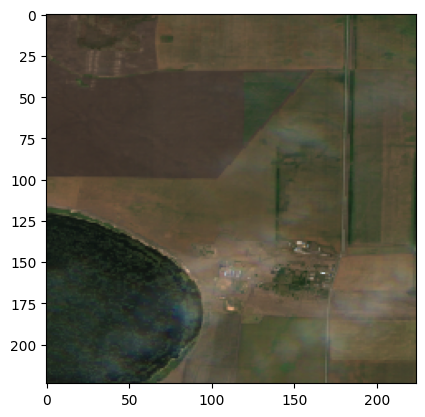

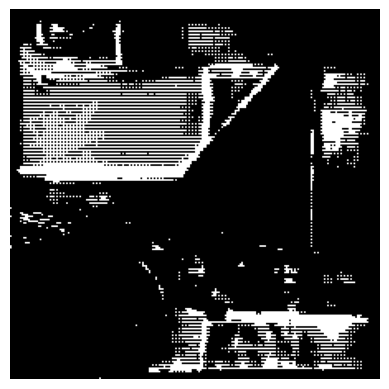

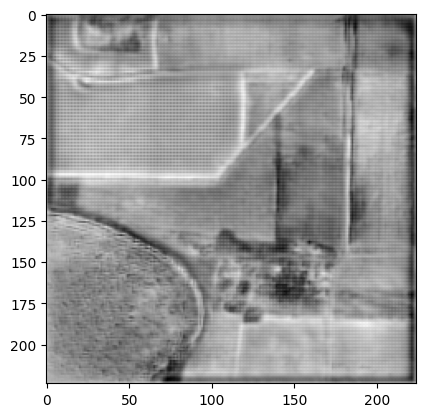

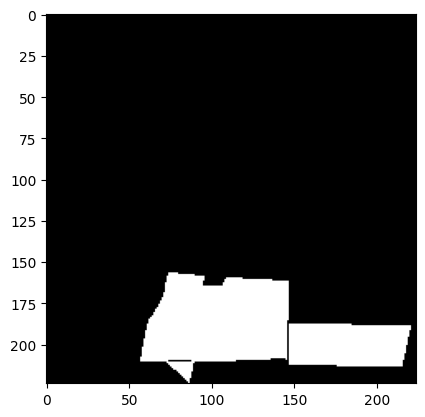

#################################################

41957_2019_img.tif 41957_2019_mask.tif
(6, 224, 224)
(224, 224)


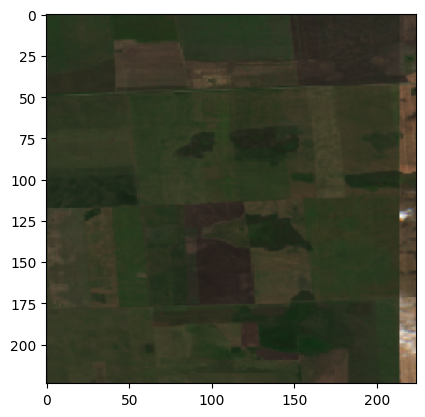

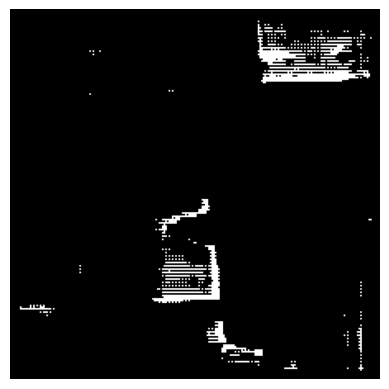

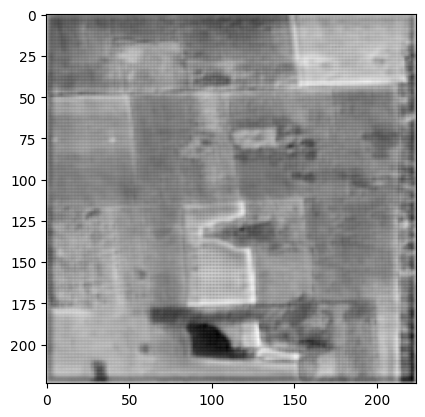

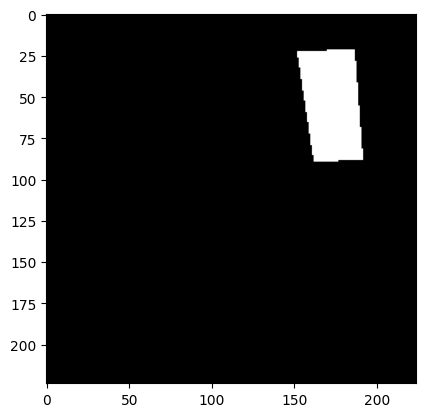

#################################################

42593_2019_img.tif 42593_2019_mask.tif
(6, 224, 224)
(224, 224)


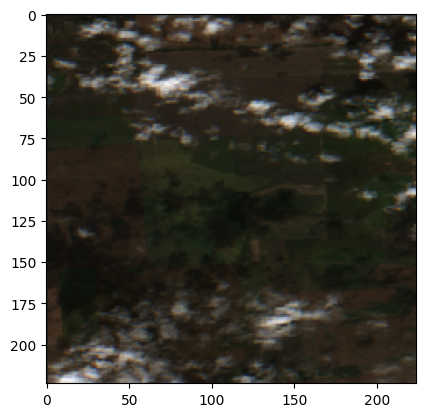

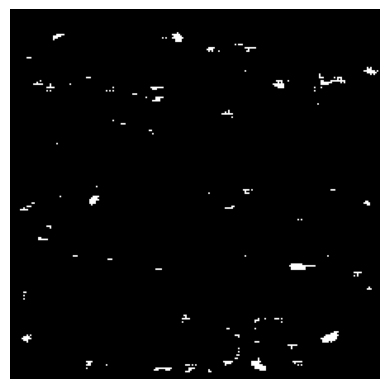

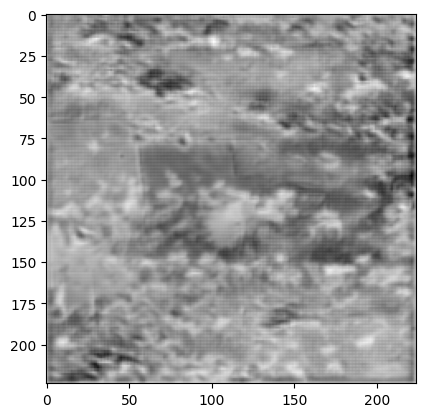

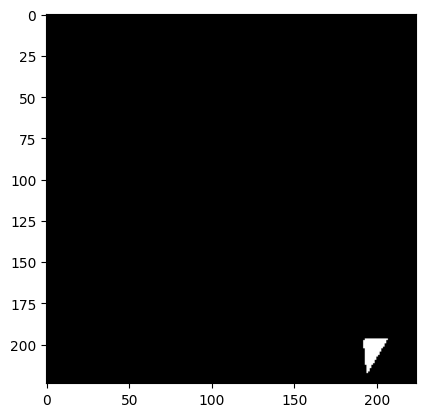

#################################################

48927_2019_img.tif 48927_2019_mask.tif
(6, 224, 224)
(224, 224)


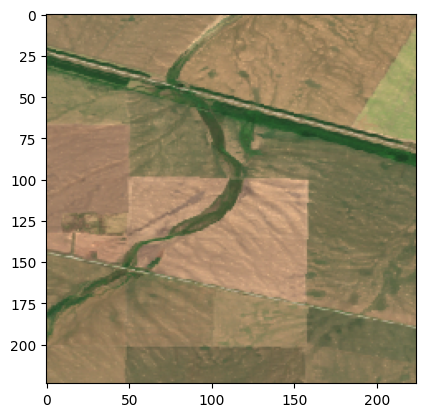

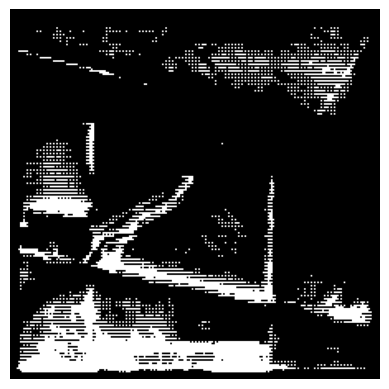

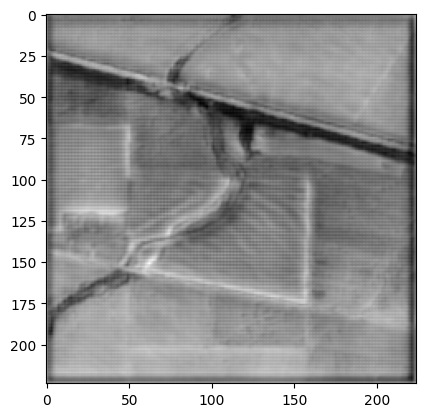

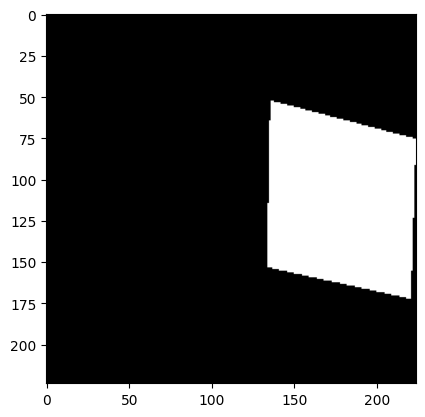

#################################################

50833_2019_img.tif 50833_2019_mask.tif
(6, 224, 224)
(224, 224)


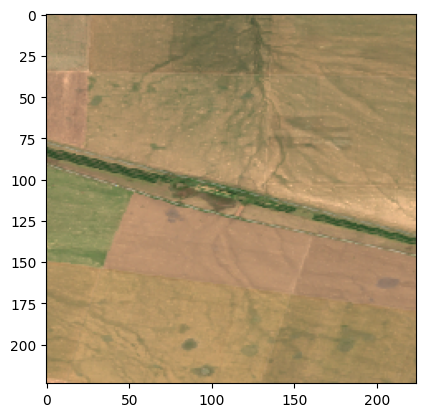

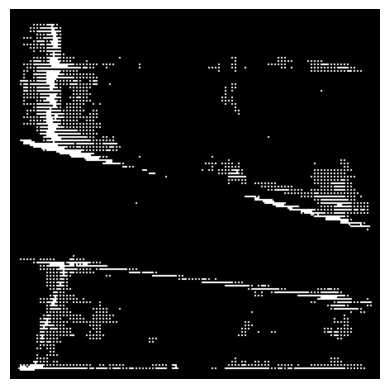

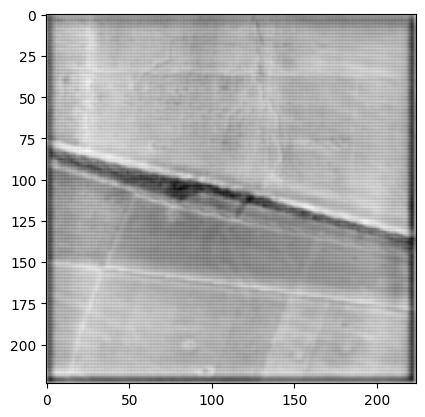

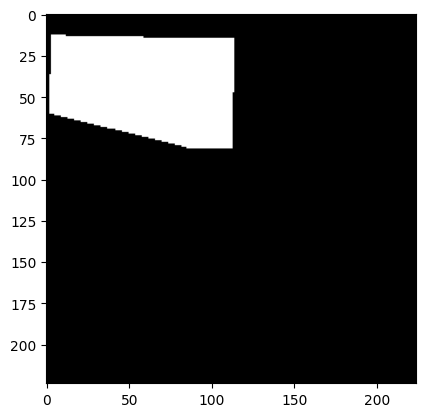

#################################################

6928_2021_img.tif 6928_2021_mask.tif
(6, 224, 224)
(224, 224)


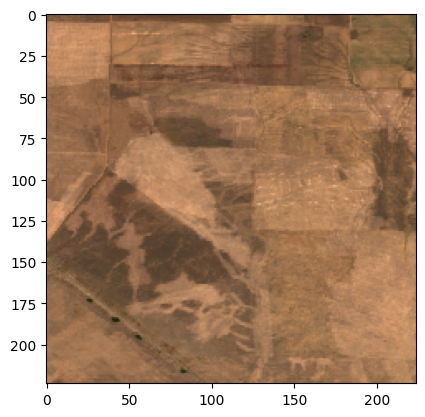

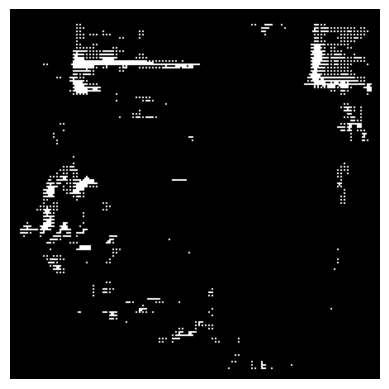

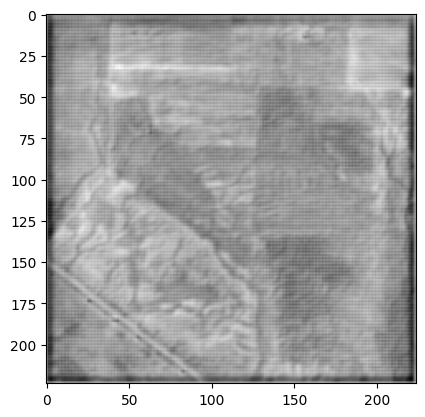

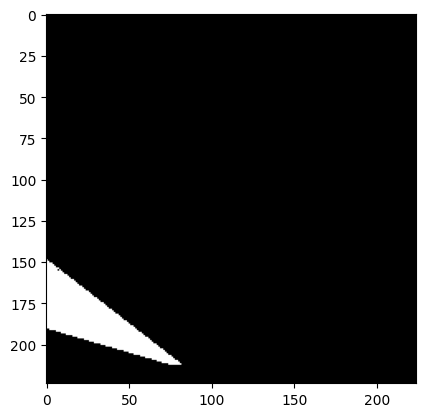

#################################################



In [452]:
images=os.listdir("/shishir/All_Datasets/Sample Kazakh 224/Images")

masks=os.listdir("/shishir/All_Datasets/Sample Kazakh 224/Masks")

for im,mk in zip(sorted(images),sorted(masks)):
    print(im, mk)

    with rasterio.open("/shishir/All_Datasets/Sample Kazakh 224/Images/"+im) as image:
        img=image.read()
        print(img.shape)
    
    with rasterio.open("/shishir/All_Datasets/Sample Kazakh 224/Masks/"+mk) as mask:
        msk=mask.read()
        print(mask.shape)
        
    test_img = np.array(img)
    
    # Convert NumPy array to PyTorch tensor
    tensor_img = torch.tensor(img,dtype=torch.float32).unsqueeze(0)
    
    # Move the tensor to CUDA device
    tensor_img_cuda = tensor_img.to("cuda")
    
    grd_truth_image = msk[0]
    # tensor_with_batch = tensor
    pred = model(tensor_img_cuda)
    
    import matplotlib.pyplot as plt
    import torch.nn.functional as F
    
    # Assuming pred[0] is your prediction tensor with shape (height, width, num_classes)
    # Convert pred[0] to a PyTorch tensor
    pred_tensor = pred[0].cpu().detach()
    
    # Apply softmax along the channel dimension
    probs = F.softmax(pred_tensor, dim=0)
    
    # Get the probability values for class 0 and class 1
    prob_class_0 = probs[0]
    prob_class_1 = probs[1]
    
    
    
    # Threshold for class 1
    threshold = 0.51
    
    # Create a mask based on the probabilities
    segmentation_mask = torch.where(prob_class_1 >= threshold, torch.tensor(1), torch.tensor(0))
    
    tensor_numpy = segmentation_mask.numpy()  # Convert the detached tensor to a NumPy array
    
    #############################
    red_band = test_img[2]
    green_band = test_img[1]
    blue_band = test_img[0]
    
    # Combine bands to create the RGB image
    rgb_image = np.dstack((red_band, green_band, blue_band))*1.0
    rgb_image = rgb_image.astype(np.float16)
    
    # Normalize each channel separately
    normalized_image = (rgb_image/rgb_image.max())*255
    normalized_image = np.uint8(normalized_image)
    
    image_rgb = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image_rgb)
    
    #######################
    image_rgb = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image_rgb)
    plt.show()
    # Plot the tensor using imshow
    plt.imshow(tensor_numpy, cmap='gray')  # Assuming the tensor represents a grayscale image
    plt.axis('off')  # Turn off axis
    plt.show()
    
    plt.imshow(pred[0][1].detach().cpu().numpy(), cmap="gray")
    plt.show()
    
    plt.imshow(grd_truth_image, cmap="gray")
    plt.show()
    print("#################################################\n")

In [13]:
k=list(train_dataset)
t_img=k[2][0]

In [14]:
t_img.shape

torch.Size([6, 224, 224])

In [51]:
t_img.shape
red_band = t_img[2]
green_band = t_img[1]
blue_band = t_img[0]

# Combine bands to create the RGB image
rgb_image = np.dstack((red_band, green_band, blue_band))*1.0
rgb_image = rgb_image.astype(np.float16)

In [14]:
# Normalize each channel separately
normalized_image = (rgb_image/rgb_image.max())*255
normalized_image = np.uint8(normalized_image)
normalized_image.dtype

NameError: name 'rgb_image' is not defined

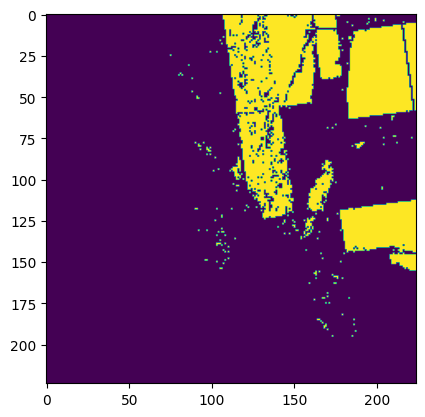

In [62]:
plt.imshow(t_img)

############################################################################################

In [15]:
# # OPTIONAL
# # Check the distribution of categories in a dataset

# labels_count = get_labels_distribution(val_dataset)
# plot_labels_distribution(labels_count)

In [12]:
len(val_dataset)

1053

In [14]:
# STEP 1-4
# Batchify the validation dataset and put it on the defined 'Device'.

val_loader = DataLoader(val_dataset, 
                        batch_size=10,
                        # config["val_test_BatchSize"], 
                        shuffle=True)

In [15]:
len(val_loader)

106

In [16]:
# STEP 1-2: Data Batching and Device Assignment
# This code cell batchifies the training dataset using the 'DataLoader' class from PyTorch. The 'DataLoader' 
# efficiently loads the 'train_dataset' in batches, facilitating memory management during training.

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          # config["train_BatchSize"], 
                          shuffle=True)

In [17]:
# import torch

# # Check CUDA compatibility
# if not torch.cuda.is_available():
#     print("CUDA is not available. Please make sure CUDA is installed and configured correctly.")
#     exit()

# # Check GPU compatibility
# device = torch.device("cuda")
# cuda_capability = torch.cuda.get_device_capability(device)
# if cuda_capability < (3, 0):
#     print("Your GPU does not meet the minimum compute capability required for PyTorch.")
#     print("Please ensure you have a CUDA-compatible GPU with compute capability at least 3.0.")
#     exit()

# # Update GPU drivers
# # Make sure you have the latest GPU drivers installed for your NVIDIA GPU.
# # Sometimes, updating the GPU drivers can resolve compatibility issues.

# # Check GPU memory
# total_memory = torch.cuda.get_device_properties(device).total_memory
# print(f"Total GPU memory: {total_memory / (1024**3):.2f} GB")
# # Verify that your GPU has enough memory to handle the model and data.
# # Loading large models or datasets that exceed the available GPU memory can cause CUDA errors.

# # Set environment variable for debugging


In [77]:
config["train_dropout_rate"]

0.15

In [176]:

# Define your model
model = Unet(n_classes= config["n_classes"], 
             in_channels=config["input_channels"], 
             use_skipAtt=False,
             # config["use_skipAtt"]
             filter_config=config["filter_config"],
             dropout_rate=0
             # config["train_dropout_rate"]
            )

# Move the model to CUDA
model.to("cuda")



Unet(
  (encoder_1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(18, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder_2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder_3): ConvBlock(
 

In [133]:
encoder_1_conv_weights = model.encoder_1.block[0].weight.data

In [134]:
model.use_skipAtt

False

In [177]:
# encoder_1_conv_weights_trunc = model.encoder_1.block[0].weight.data


In [178]:
# Truncate the weights to contain only the first 6 channels
encoder_1_conv_weights_truncated = encoder_1_conv_weights[:, :6, :, :]
# Modify the model's weights with the truncated weights
model.encoder_1.block[0] = nn.Conv2d(6, 64, kernel_size=(3,3), stride=1, padding=1, bias=False)
model.encoder_1.block[0].weight.data = encoder_1_conv_weights_truncated

In [179]:
# You can print the modified weights to verify
print(model.encoder_1.block[0].weight.data.shape)

torch.Size([64, 6, 3, 3])


In [180]:
# Modify the classifier layer
model.classifier = nn.Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))

In [181]:
# load previously trained model
checkpoint_path = "/shishir/multi-temporal-crop-classification-baseline/output6/Unet_ep1000/all_trainable_no_dropout/chkpt/Unet_final_state.pth"
# "/shishir/multi-temporal-crop-classification-baseline/model_weights/multi_temporal_crop_classification.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda')) # or use GPU

# Remove 'module.' prefix if present (for nn.DataParallel compatibility)
new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [140]:
# old_weights=model.encoder_2.block[0]
# old_weights

In [141]:
# new_weights=model.encoder_2.block[0]


In [142]:
model.use_skipAtt

False

In [143]:
# import torch

# # Assuming new_weights1 and new_weights2 are the weights tensors from two instances
# # of the same layer (encoder_2.block[0])

# # Compare if all weights are the same
# all_weights_same = torch.allclose(old_weights.weight, new_weights.weight)

# if all_weights_same:
#     print("All weights in the layer are the same.")
# else:
#     print("Weights in the layer are not the same.")


In [144]:
model.use_skipAtt=True
model.add_attention_blocks()

In [145]:
# new_weights=model.encoder_2.block[0]
for name, param in model.named_parameters():
    if 'Att' in name:  # Check if the parameter belongs to an attention block
        print(name)

Att1.W_g.0.weight
Att1.W_g.0.bias
Att1.W_g.1.weight
Att1.W_g.1.bias
Att1.W_x.0.weight
Att1.W_x.0.bias
Att1.W_x.1.weight
Att1.W_x.1.bias
Att1.psi.0.weight
Att1.psi.0.bias
Att1.psi.1.weight
Att1.psi.1.bias
Att2.W_g.0.weight
Att2.W_g.0.bias
Att2.W_g.1.weight
Att2.W_g.1.bias
Att2.W_x.0.weight
Att2.W_x.0.bias
Att2.W_x.1.weight
Att2.W_x.1.bias
Att2.psi.0.weight
Att2.psi.0.bias
Att2.psi.1.weight
Att2.psi.1.bias
Att3.W_g.0.weight
Att3.W_g.0.bias
Att3.W_g.1.weight
Att3.W_g.1.bias
Att3.W_x.0.weight
Att3.W_x.0.bias
Att3.W_x.1.weight
Att3.W_x.1.bias
Att3.psi.0.weight
Att3.psi.0.bias
Att3.psi.1.weight
Att3.psi.1.bias
Att4.W_g.0.weight
Att4.W_g.0.bias
Att4.W_g.1.weight
Att4.W_g.1.bias
Att4.W_x.0.weight
Att4.W_x.0.bias
Att4.W_x.1.weight
Att4.W_x.1.bias
Att4.psi.0.weight
Att4.psi.0.bias
Att4.psi.1.weight
Att4.psi.1.bias
Att5.W_g.0.weight
Att5.W_g.0.bias
Att5.W_g.1.weight
Att5.W_g.1.bias
Att5.W_x.0.weight
Att5.W_x.0.bias
Att5.W_x.1.weight
Att5.W_x.1.bias
Att5.psi.0.weight
Att5.psi.0.bias
Att5.psi.1.wei

In [146]:
# Freeze all parameters except attention weights
for name, param in model.named_parameters():
    if 'Att' in name:  # Check if the parameter belongs to an attention block
        param.requires_grad = True
    else:
        param.requires_grad = False

In [161]:
# Optionally, you can also set specific layers to require gradients
for name, param in model.named_parameters():
    if 'decoder' in name or "conv" in name or "classifier" in name:
        param.requires_grad = True

In [163]:
# Optionally, you can print which parameters are trainable now
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

encoder_1.block.0.weight: requires_grad=False
encoder_1.block.1.weight: requires_grad=False
encoder_1.block.1.bias: requires_grad=False
encoder_1.block.3.weight: requires_grad=False
encoder_1.block.4.weight: requires_grad=False
encoder_1.block.4.bias: requires_grad=False
encoder_2.block.0.weight: requires_grad=False
encoder_2.block.1.weight: requires_grad=False
encoder_2.block.1.bias: requires_grad=False
encoder_2.block.3.weight: requires_grad=False
encoder_2.block.4.weight: requires_grad=False
encoder_2.block.4.bias: requires_grad=False
encoder_3.block.0.weight: requires_grad=False
encoder_3.block.1.weight: requires_grad=False
encoder_3.block.1.bias: requires_grad=False
encoder_3.block.3.weight: requires_grad=False
encoder_3.block.4.weight: requires_grad=False
encoder_3.block.4.bias: requires_grad=False
encoder_4.block.0.weight: requires_grad=False
encoder_4.block.1.weight: requires_grad=False
encoder_4.block.1.bias: requires_grad=False
encoder_4.block.3.weight: requires_grad=False
en

In [158]:
model

Unet(
  (encoder_1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder_2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder_3): ConvBlock(
    (block

In [148]:
import torch

# Assuming 'model' is your PyTorch model
device = next(model.parameters()).device
if device.type == 'cuda':
    print("Model is on GPU")
else:
    print("Model is on CPU")


Model is on GPU


In [130]:
# def freeze_layers(model, freeze_until='encoder_5'):
#     freeze = False
#     for name, module in model.named_children():
#         # if freeze_until in name:
#         #     freeze = True
#         # elif not freeze:
#         for param in module.parameters():
#             param.requires_grad = True

# # Assuming model is already instantiated and named "model"
# freeze_layers(model)


In [195]:
# model = nn.DataParallel(model)

# Move the model to CUDA
# model.to("cuda")

In [164]:
# STEP 3: Model Compilation and Training Setup
# This code cell compiles the deep learning model, making it ready for training and evaluation. The 'ModelCompiler' 
# class is employed for this purpose, which offers a set of essential functionalities, such as model training 
# ('fit'), model saving, accuracy evaluation ('accuracy_evaluation'), inference ('inference'), and checkpointing 
# with resume capabilities. Additionally, it generates tensorboard reports and graphs for monitoring the training 
# process.

# Note: For training from scratch pass the "params_init" and "freeze_params" as None which results in loading a vanilla
# model with random initialization based on the "model_init_type" parameter. For training with warmup, only change the
# "params_init" to the path to model's saved parameter (not a checkpoint). For fine-tuning, change the "params_init" to 
# the path to model's saved parameter (by default its in the chckpt folder in working directory) and pass a list of integers
# representing the index of layers to be frozen.


# import torch.nn as nn

# # Wrap your model with DataParallel


compiled_model = ModelCompiler(model,
                               working_dir=config["working_dir"],
                               out_dir=config["out_dir"],
                               num_classes=2,
                               # config["n_classes"],
                               inch=config["input_channels"],
                               class_mapping=config["class_mapping"],
                               gpu_devices=[0],
                               # config["gpuDevices"],
                               model_init_type=config["init_type"], 
                               params_init=config["params_init"],
                               freeze_params=config["freeze_params"],
                              checkpoint_name="atten_plus_decoder_only_trained_no_dropout")

atten_plus_decoder_only_trained_no_dropout ##########################################################################
----------GPU available----------
total number of trainable parameters: 67.0M
---------- Vanilla Model compiled successfully ----------


In [338]:
config["gpuDevices"]

[0]

In [339]:
# # Load pre-trained weights
# pretrained_weights_path = '/shishir/multi-temporal-crop-classification-baseline/model_weights/multi_temporal_crop_classification.pth'
# model.load_state_dict(torch.load(pretrained_weights_path))

In [340]:
# import torch

# # Check if CUDA (GPU) is available
# if torch.cuda.is_available():
#     # If CUDA is available, move the model to the GPU
#     device = torch.device("cuda")
#     model.to(device)
#     print("Model pushed to CUDA")
# else:
#     print("CUDA is not available. Model remains on CPU.")


In [341]:
# # Check if weights are trainable
# for name, param in model.named_parameters():
#     print(f'Parameter: {name}, Requires grad: {param.requires_grad}')


In [370]:
config['criterion']['weight']

[0.0182553,
 0.03123664,
 0.02590038,
 0.03026126,
 0.04142966,
 0.04371284,
 0.15352935,
 0.07286951,
 0.10277024,
 0.10736637,
 0.1447082,
 0.17132445,
 0.0566358]

In [165]:
# STEP 4: Model Training and Validation
# This code cell trains and validates the compiled deep learning model for the specified number of epochs. 
# The model is trained using the "fit" method provided by the 'compiled_model' object. The training data 
# is obtained from 'train_loader', which contains batched samples and labels. Additionally, the 'val_loader' 
# is used for model validation during training. For each epoch the model reports the average loss value for both 
# training and validation phases, providing insights into its generalization capabilities.

# During the training the "fit" method will create a folder called 'chkpt' inside your working directory
# and save the checkpoints in user-defined intervals in that folder.
# Note: In case the training process is interrupted, you can change the "resume" argument and pass in the
# epoch to resume based on the created checkpoints.

criterion_name = config['criterion']['name']
weight = config['criterion']['weight']
ignore_index = config['criterion']['ignore_index']
gamma = config['criterion']['gamma']

if criterion_name == 'TverskyFocalLoss':
    criterion = TverskyFocalLoss(weight=None, ignore_index=ignore_index, gamma=gamma)
else:
    criterion = nn.CrossEntropyLoss(weight=None, ignore_index=ignore_index)
    
compiled_model.fit(train_loader,
                   val_loader,
                   checkpoint_name="atten_plus_decoder_only_trained_no_dropout",
                   epochs=1000, 
                   optimizer_name=config["optimizer"], 
                   lr_init=config["LR"],
                   lr_policy=config["LR_policy"], 
                   criterion=criterion, 
                   momentum=config["momentum"],
                   checkpoint_interval=50,
                   # config["checkpoint_interval"],
                   resume=config["resume"],
                   resume_epoch=config["resume_epoch"],
                   **config["lr_prams"])
# "/shishir/multi-temporal-crop-classification-baseline/output6/Unet_ep30/chkpt/Unet_final_state.pth"
# multi-temporal-crop-classification-baseline/output6/DataParallel_ep1000/encoder_5_onwrads_1000_epochs/chkpt/training.log

117
/shishir/multi-temporal-crop-classification-baseline/output6/Unet_ep1000/atten_plus_decoder_only_trained_no_dropout/chkpt
/shishir/multi-temporal-crop-classification-baseline/output6/Unet_ep1000/atten_plus_decoder_only_trained_no_dropout/chkpt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08803645435434121


106it [00:05, 18.79it/s]


validation loss: 0.2015
LR: 0.01088407840200658
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [01:03<00:00,  1.85it/s]


train loss:0.08860085630773479


106it [00:04, 25.50it/s]


validation loss: 0.2067
LR: 0.01088407840200658
time: 67


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:48<00:00,  2.42it/s]


train loss:0.08813786519388868


106it [00:04, 24.96it/s]


validation loss: 0.2088
LR: 0.01076793648428988
time: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:48<00:00,  2.43it/s]


train loss:0.08834541926526615


106it [00:04, 24.48it/s]


validation loss: 0.2013
LR: 0.010651570995243713
time: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:48<00:00,  2.42it/s]


train loss:0.08842242177989748


106it [00:04, 23.68it/s]


validation loss: 0.2019
LR: 0.010534978592374402
time: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:48<00:00,  2.43it/s]


train loss:0.08782882157426614


106it [00:04, 23.24it/s]


validation loss: 0.1982
LR: 0.010418155838529623
time: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:48<00:00,  2.42it/s]


train loss:0.08807188336156373


106it [00:04, 23.86it/s]


validation loss: 0.2049
LR: 0.0103010991979183
time: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:48<00:00,  2.41it/s]


train loss:0.0879964921464268


106it [00:04, 25.52it/s]


validation loss: 0.2061
LR: 0.010183805031907068
time: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:49<00:00,  2.38it/s]


train loss:0.08797070988987246


106it [00:05, 20.37it/s]


validation loss: 0.2011
LR: 0.010066269594577452
time: 54


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.29it/s]


train loss:0.08756212304290543


106it [00:04, 21.23it/s]


validation loss: 0.2015
LR: 0.009948489028026699
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:50<00:00,  2.31it/s]


train loss:0.08763229327960911


106it [00:04, 21.73it/s]


validation loss: 0.1950
LR: 0.009830459357393576
time: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.27it/s]


train loss:0.08763400178689223


106it [00:05, 20.12it/s]


validation loss: 0.2050
LR: 0.00971217648558892
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08747771856749159


106it [00:05, 19.58it/s]


validation loss: 0.1960
LR: 0.009593636187708865
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08735092299488875


106it [00:04, 23.41it/s]


validation loss: 0.1984
LR: 0.009474834105106671
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08694001917655651


106it [00:05, 19.08it/s]


validation loss: 0.1958
LR: 0.009355765739096885
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.08661894360159197


106it [00:04, 21.91it/s]


validation loss: 0.1991
LR: 0.009236426444263108
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.29it/s]


train loss:0.08698412355704185


106it [00:04, 23.28it/s]


validation loss: 0.1997
LR: 0.009116811421337918
time: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:50<00:00,  2.30it/s]


train loss:0.08701040235976888


106it [00:05, 18.73it/s]


validation loss: 0.2007
LR: 0.008996915709620482
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.28it/s]


train loss:0.08599062146157281


106it [00:04, 21.93it/s]


validation loss: 0.2033
LR: 0.008876734178893973
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:50<00:00,  2.31it/s]


train loss:0.08661004117666146


106it [00:04, 22.34it/s]


validation loss: 0.1984
LR: 0.008756261520801238
time: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.29it/s]


train loss:0.08595564375575791


106it [00:05, 20.88it/s]


validation loss: 0.1979
LR: 0.008635492239632885
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.25it/s]


train loss:0.08592292590019031


106it [00:04, 21.81it/s]


validation loss: 0.1975
LR: 0.008514420642477247
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.27it/s]


train loss:0.08624505961680004


106it [00:04, 21.28it/s]


validation loss: 0.2013
LR: 0.008393040828676514
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.08587267300766757


106it [00:04, 21.73it/s]


validation loss: 0.2062
LR: 0.008271346678527249
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08613322235834904


106it [00:05, 20.56it/s]


validation loss: 0.2030
LR: 0.008149331841156956
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.25it/s]


train loss:0.08560231343930604


106it [00:05, 18.95it/s]


validation loss: 0.1988
LR: 0.008026989721500798
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08563499362804951


106it [00:05, 20.92it/s]


validation loss: 0.1998
LR: 0.00790431346629404
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08586770276992749


106it [00:04, 21.71it/s]


validation loss: 0.1998
LR: 0.0077812959489862174
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:49<00:00,  2.35it/s]


train loss:0.08579003546609838


106it [00:04, 22.08it/s]


validation loss: 0.1984
LR: 0.007657929753472054
time: 54


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:50<00:00,  2.30it/s]


train loss:0.08573636899773891


106it [00:05, 19.07it/s]


validation loss: 0.2042
LR: 0.007534207156521739
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.29it/s]


train loss:0.08495844973840265


106it [00:05, 20.34it/s]


validation loss: 0.2047
LR: 0.007410120108778984
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.21it/s]


train loss:0.08548147148556179


106it [00:05, 19.78it/s]


validation loss: 0.2029
LR: 0.007285660214179062
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.25it/s]


train loss:0.08504401828743453


106it [00:05, 20.70it/s]


validation loss: 0.2024
LR: 0.007160818707620457
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08524052700043744


106it [00:05, 19.64it/s]


validation loss: 0.2058
LR: 0.00703558643070238
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:55<00:00,  2.10it/s]


train loss:0.08502284517018203


106it [00:26,  4.03it/s]


validation loss: 0.2022
LR: 0.006909953805315782
time: 81


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08503019434009862


106it [00:06, 17.37it/s]


validation loss: 0.2041
LR: 0.006783910804847085
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.08474603091549669


106it [00:06, 16.99it/s]


validation loss: 0.2010
LR: 0.006657446922720798
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.0848376139297954


106it [00:04, 21.55it/s]


validation loss: 0.2062
LR: 0.00653055113796892
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.17it/s]


train loss:0.08454095674121481


106it [00:05, 19.01it/s]


validation loss: 0.2011
LR: 0.006403211877470193
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.08481797467694323


106it [00:05, 20.64it/s]


validation loss: 0.2021
LR: 0.006275416974449949
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08465810744171469


106it [00:05, 19.31it/s]


validation loss: 0.1995
LR: 0.006147153622769756
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.08429062430165772


106it [00:05, 19.24it/s]


validation loss: 0.2045
LR: 0.006018408326463413
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.08438035520987633


106it [00:06, 17.54it/s]


validation loss: 0.2032
LR: 0.005889166843890066
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.17it/s]


train loss:0.08419448506628346


106it [00:05, 18.26it/s]


validation loss: 0.2018
LR: 0.005759414125772965
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08363397422636676


106it [00:05, 20.33it/s]


validation loss: 0.2000
LR: 0.00562913424627056
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.21it/s]


train loss:0.08410340942378737


106it [00:06, 17.53it/s]


validation loss: 0.2064
LR: 0.005498310326080407
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.18it/s]


train loss:0.08440198634679501


106it [00:05, 19.30it/s]


validation loss: 0.2039
LR: 0.005366924446400158
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.08393922279405798


106it [00:05, 20.02it/s]


validation loss: 0.2015
LR: 0.005234957552356689
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.17it/s]


train loss:0.08362848499519193


106it [00:05, 20.89it/s]


validation loss: 0.2055
LR: 0.005102389344254616
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08361255094154268


106it [00:04, 21.58it/s]


validation loss: 0.2020
LR: 0.004969198154677598
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.29it/s]


train loss:0.0837929789454509


106it [00:05, 20.55it/s]


validation loss: 0.2030
LR: 0.004835360809084325
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08409456895966815


106it [00:04, 22.41it/s]


validation loss: 0.2047
LR: 0.004700852467055843
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08337173763758098


106it [00:04, 21.39it/s]


validation loss: 0.2048
LR: 0.0045656464407457095
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.27it/s]


train loss:0.08321390450637564


106it [00:05, 21.13it/s]


validation loss: 0.2027
LR: 0.004429713986323926
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08354451609218222


106it [00:05, 20.09it/s]


validation loss: 0.2017
LR: 0.004293024063242922
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.0831775856960533


106it [00:04, 21.75it/s]


validation loss: 0.2006
LR: 0.004155543054925218
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08335998988686463


106it [00:04, 22.06it/s]


validation loss: 0.2038
LR: 0.004017234442890598
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.082484760058996


106it [00:04, 23.57it/s]


validation loss: 0.2060
LR: 0.003878058424285322
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.25it/s]


train loss:0.08276258459967425


106it [00:05, 18.17it/s]


validation loss: 0.1995
LR: 0.0037379714600781155
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.27it/s]


train loss:0.083326836490733


106it [00:05, 19.61it/s]


validation loss: 0.2043
LR: 0.003596925737608185
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.28it/s]


train loss:0.08355969231989649


106it [00:05, 20.48it/s]


validation loss: 0.2035
LR: 0.003454868526364897
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.21it/s]


train loss:0.08334173020134625


106it [00:05, 20.62it/s]


validation loss: 0.2051
LR: 0.003311741399343887
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08279351367909685


106it [00:05, 20.17it/s]


validation loss: 0.2023
LR: 0.0031674792833133337
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [01:01<00:00,  1.91it/s]


train loss:0.08255671591967599


106it [00:08, 11.87it/s]


validation loss: 0.2028
LR: 0.0030220092887067247
time: 70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08242807718805778


106it [00:05, 18.98it/s]


validation loss: 0.2023
LR: 0.0028752492518912026
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.29it/s]


train loss:0.08345380661069837


106it [00:05, 20.94it/s]


validation loss: 0.2028
LR: 0.0027271058964932287
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.25it/s]


train loss:0.08255228734551331


106it [00:05, 19.54it/s]


validation loss: 0.2066
LR: 0.0025774724818499344
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.16it/s]


train loss:0.08293006441786759


106it [00:05, 20.54it/s]


validation loss: 0.2048
LR: 0.0024262257481101096
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.25it/s]


train loss:0.08268798693505108


106it [00:05, 18.05it/s]


validation loss: 0.2065
LR: 0.0022732218763820496
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08235495324190865


106it [00:05, 19.73it/s]


validation loss: 0.2041
LR: 0.00211829103617838
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.17it/s]


train loss:0.08220770709917076


106it [00:05, 19.30it/s]


validation loss: 0.2025
LR: 0.001961229849827864
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.21it/s]


train loss:0.08299465235481915


106it [00:04, 21.42it/s]


validation loss: 0.2024
LR: 0.0018017906844825142
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08299372236952822


106it [00:05, 21.05it/s]


validation loss: 0.2067
LR: 0.0016396659236388022
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.25it/s]


train loss:0.082487380084319


106it [00:05, 19.93it/s]


validation loss: 0.2022
LR: 0.0014744639168744228
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.0825747825905808


106it [00:06, 16.23it/s]


validation loss: 0.2083
LR: 0.0013056703250317605
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.08223363652061193


106it [00:06, 17.50it/s]


validation loss: 0.2075
LR: 0.001132581910935209
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.18it/s]


train loss:0.08208814951089713


106it [00:05, 19.61it/s]


validation loss: 0.2066
LR: 0.000954183153026379
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.19it/s]


train loss:0.08200871371305905


106it [00:05, 18.97it/s]


validation loss: 0.2041
LR: 0.0007688874930166788
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08225777748430896


106it [00:05, 19.24it/s]


validation loss: 0.2076
LR: 0.0005738877750763634
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.0821278452172748


106it [00:05, 18.31it/s]


validation loss: 0.2020
LR: 0.00036290570420544207
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.18it/s]


train loss:0.08281200012972212


106it [00:06, 16.48it/s]


validation loss: 0.2056
LR: 0.0001
time: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.21it/s]


train loss:0.08236224920703815


106it [00:05, 19.40it/s]


validation loss: 0.2043
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.16it/s]


train loss:0.08231974622377983


106it [00:05, 18.49it/s]


validation loss: 0.2095
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.21it/s]


train loss:0.08252446786460714


106it [00:05, 18.78it/s]


validation loss: 0.2059
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.27it/s]


train loss:0.08239765207354839


106it [00:04, 22.65it/s]


validation loss: 0.2042
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08213878432527566


106it [00:06, 15.24it/s]


validation loss: 0.2034
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.28it/s]


train loss:0.08183369817387344


106it [00:04, 21.35it/s]


validation loss: 0.2019
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.25it/s]


train loss:0.08215839957070147


106it [00:05, 20.02it/s]


validation loss: 0.2044
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:50<00:00,  2.32it/s]


train loss:0.08251979402624644


106it [00:05, 20.08it/s]


validation loss: 0.2061
LR: 0.0001
time: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.0822537464973254


106it [00:04, 23.01it/s]


validation loss: 0.2068
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.0822119023810085


106it [00:04, 21.99it/s]


validation loss: 0.2054
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.28it/s]


train loss:0.08242464482656911


106it [00:06, 15.46it/s]


validation loss: 0.2063
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08203864409628077


106it [00:04, 21.54it/s]


validation loss: 0.2059
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.25it/s]


train loss:0.08221707069593617


106it [00:04, 21.54it/s]


validation loss: 0.2038
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.08205048036244181


106it [00:05, 21.06it/s]


validation loss: 0.2081
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08192994961371788


106it [00:04, 22.88it/s]


validation loss: 0.2060
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.27it/s]


train loss:0.08198164540350947


106it [00:05, 20.42it/s]


validation loss: 0.2023
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.27it/s]


train loss:0.08246648693696046


106it [00:04, 21.71it/s]


validation loss: 0.2027
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08235278805224304


106it [00:05, 19.58it/s]


validation loss: 0.2059
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.21it/s]


train loss:0.08215954014633456


106it [00:04, 23.00it/s]


validation loss: 0.2070
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.0826332570077517


106it [00:04, 23.66it/s]


validation loss: 0.2065
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.08227833061136751


106it [00:05, 20.29it/s]


validation loss: 0.2064
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08272524353148591


106it [00:04, 21.25it/s]


validation loss: 0.2058
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.18it/s]


train loss:0.0825048003377568


106it [00:05, 20.80it/s]


validation loss: 0.2087
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.0819932746135781


106it [00:04, 22.37it/s]


validation loss: 0.2053
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.0825254915552771


106it [00:05, 20.60it/s]


validation loss: 0.2043
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08236201578735286


106it [00:05, 20.38it/s]


validation loss: 0.2027
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.16it/s]


train loss:0.08260388303006816


106it [00:05, 20.31it/s]


validation loss: 0.2044
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.0817194294789408


106it [00:05, 19.02it/s]


validation loss: 0.2112
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.15it/s]


train loss:0.0822927582786124


106it [00:05, 17.93it/s]


validation loss: 0.2027
LR: 0.0001
time: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.18it/s]


train loss:0.0822183671924803


106it [00:05, 20.08it/s]


validation loss: 0.2078
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.19it/s]


train loss:0.08255022165612277


106it [00:05, 18.98it/s]


validation loss: 0.2067
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.14it/s]


train loss:0.08229314898833251


106it [00:05, 19.12it/s]


validation loss: 0.2057
LR: 0.0001
time: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.0824026935057253


106it [00:05, 18.46it/s]


validation loss: 0.2048
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.08237991462915371


106it [00:05, 18.17it/s]


validation loss: 0.2033
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08271020972448537


106it [00:05, 19.69it/s]


validation loss: 0.2050
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.19it/s]


train loss:0.08245210607464497


106it [00:05, 18.65it/s]


validation loss: 0.2053
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:55<00:00,  2.09it/s]


train loss:0.08187594487626329


106it [00:05, 18.07it/s]


validation loss: 0.2001
LR: 0.0001
time: 61


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.18it/s]


train loss:0.08224332135202539


106it [00:05, 20.71it/s]


validation loss: 0.2022
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:55<00:00,  2.13it/s]


train loss:0.0821245012120304


106it [00:05, 19.30it/s]


validation loss: 0.2036
LR: 0.0001
time: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08248868692889173


106it [00:05, 18.72it/s]


validation loss: 0.2079
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.28it/s]


train loss:0.08222122901143172


106it [00:05, 17.94it/s]


validation loss: 0.2025
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:50<00:00,  2.31it/s]


train loss:0.08210986429172704


106it [00:05, 21.14it/s]


validation loss: 0.2059
LR: 0.0001
time: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:50<00:00,  2.30it/s]


train loss:0.08195095588890915


106it [00:04, 21.78it/s]


validation loss: 0.2040
LR: 0.0001
time: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08249402167195947


106it [00:04, 22.61it/s]


validation loss: 0.2044
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.21it/s]


train loss:0.08199028234578605


106it [00:05, 19.52it/s]


validation loss: 0.2114
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.0816478983968751


106it [00:04, 23.21it/s]


validation loss: 0.2042
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.14it/s]


train loss:0.0825512308595527


106it [00:09, 10.74it/s]


validation loss: 0.2057
LR: 0.0001
time: 64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08197871837605777


106it [00:07, 14.25it/s]


validation loss: 0.2047
LR: 0.0001
time: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:55<00:00,  2.10it/s]


train loss:0.08181909105589247


106it [00:05, 20.64it/s]


validation loss: 0.2038
LR: 0.0001
time: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.29it/s]


train loss:0.08168558037688589


106it [00:05, 20.95it/s]


validation loss: 0.2047
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.17it/s]


train loss:0.08189350968370071


106it [00:05, 18.69it/s]


validation loss: 0.2028
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.27it/s]


train loss:0.0819781819660949


106it [00:05, 18.72it/s]


validation loss: 0.2066
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.0829060219355628


106it [00:05, 20.44it/s]


validation loss: 0.2051
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.08244545971099128


106it [00:04, 22.60it/s]


validation loss: 0.2082
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08264443265576647


106it [00:05, 17.80it/s]


validation loss: 0.2059
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.25it/s]


train loss:0.0823599331271954


106it [00:04, 21.87it/s]


validation loss: 0.2055
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08264793200880034


106it [00:04, 21.70it/s]


validation loss: 0.2039
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.21it/s]


train loss:0.08174797007416049


106it [00:05, 17.90it/s]


validation loss: 0.2026
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.18it/s]


train loss:0.08215387665435799


106it [00:05, 20.70it/s]


validation loss: 0.2043
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.08283291964067353


106it [00:05, 20.31it/s]


validation loss: 0.2032
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08232197534834218


106it [00:05, 18.36it/s]


validation loss: 0.2064
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.25it/s]


train loss:0.08181214864310037


106it [00:05, 19.27it/s]


validation loss: 0.2046
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08178497701246515


106it [00:05, 18.97it/s]


validation loss: 0.2037
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.15it/s]


train loss:0.08234420676644032


106it [00:05, 20.22it/s]


validation loss: 0.2069
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.21it/s]


train loss:0.08232598216869892


106it [00:05, 20.06it/s]


validation loss: 0.2030
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.082121727303562


106it [00:05, 17.67it/s]


validation loss: 0.2044
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.08224495634054527


106it [00:05, 18.81it/s]


validation loss: 0.2039
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:55<00:00,  2.12it/s]


train loss:0.08236694918611111


106it [00:06, 17.53it/s]


validation loss: 0.2035
LR: 0.0001
time: 61


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.08227208412737928


106it [00:05, 20.28it/s]


validation loss: 0.2064
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.18it/s]


train loss:0.08183242469771296


106it [00:05, 19.20it/s]


validation loss: 0.2071
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.16it/s]


train loss:0.08223600774748713


106it [00:06, 17.10it/s]


validation loss: 0.2034
LR: 0.0001
time: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.21it/s]


train loss:0.08206494162097955


106it [00:06, 16.23it/s]


validation loss: 0.2057
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [01:07<00:00,  1.74it/s]


train loss:0.0821298740676835


106it [00:06, 16.13it/s]


validation loss: 0.2030
LR: 0.0001
time: 74


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.19it/s]


train loss:0.08199083333850926


106it [00:05, 18.18it/s]


validation loss: 0.2060
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.16it/s]


train loss:0.0817498806068021


106it [00:06, 16.97it/s]


validation loss: 0.2044
LR: 0.0001
time: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.24it/s]


train loss:0.08257056495700127


106it [00:04, 21.89it/s]


validation loss: 0.2062
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.21it/s]


train loss:0.08229889548741855


106it [00:04, 21.26it/s]


validation loss: 0.2073
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08232654054832254


106it [00:04, 21.52it/s]


validation loss: 0.2059
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.21it/s]


train loss:0.08201410274347688


106it [00:05, 20.84it/s]


validation loss: 0.2062
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.0822412363675415


106it [00:04, 23.72it/s]


validation loss: 0.2021
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.15it/s]


train loss:0.08188118928900132


106it [00:04, 21.66it/s]


validation loss: 0.2077
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.21it/s]


train loss:0.08164854580138484


106it [00:04, 22.61it/s]


validation loss: 0.2077
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08206718596510398


106it [00:05, 18.41it/s]


validation loss: 0.2055
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.28it/s]


train loss:0.08249011218675181


106it [00:04, 23.44it/s]


validation loss: 0.2054
LR: 0.0001
time: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:55<00:00,  2.12it/s]


train loss:0.0824255562809288


106it [00:05, 19.63it/s]


validation loss: 0.2057
LR: 0.0001
time: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:50<00:00,  2.31it/s]


train loss:0.08230192554939507


106it [00:04, 21.80it/s]


validation loss: 0.2059
LR: 0.0001
time: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.28it/s]


train loss:0.08227600478845784


106it [00:04, 21.89it/s]


validation loss: 0.2058
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.20it/s]


train loss:0.08228214448079085


106it [00:05, 20.40it/s]


validation loss: 0.2052
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.27it/s]


train loss:0.08191180334259303


106it [00:05, 20.44it/s]


validation loss: 0.2035
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.28it/s]


train loss:0.08207770857291344


106it [00:05, 19.58it/s]


validation loss: 0.2078
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08237467384618571


106it [00:04, 22.44it/s]


validation loss: 0.2035
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.25it/s]


train loss:0.08170392679480407


106it [00:04, 21.89it/s]


validation loss: 0.2077
LR: 0.0001
time: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.23it/s]


train loss:0.08194783027482848


106it [00:05, 20.77it/s]


validation loss: 0.2040
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.22it/s]


train loss:0.08260867091962415


106it [00:05, 19.26it/s]


validation loss: 0.2033
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:56<00:00,  2.06it/s]


train loss:0.08188006441053162


106it [00:05, 20.27it/s]


validation loss: 0.2073
LR: 0.0001
time: 62


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.27it/s]


train loss:0.08209580014276709


106it [00:06, 15.58it/s]


validation loss: 0.2055
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.21it/s]


train loss:0.08132792958337018


106it [00:04, 21.68it/s]


validation loss: 0.2059
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.0819509323590841


106it [00:05, 19.17it/s]


validation loss: 0.2111
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.17it/s]


train loss:0.08234369203957737


106it [00:05, 18.09it/s]


validation loss: 0.2049
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:51<00:00,  2.26it/s]


train loss:0.08236086301696606


106it [00:05, 19.59it/s]


validation loss: 0.2073
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:52<00:00,  2.25it/s]


train loss:0.0818579464386671


106it [00:05, 19.89it/s]


validation loss: 0.2075
LR: 0.0001
time: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.19it/s]


train loss:0.08217427908227994


106it [00:05, 21.02it/s]


validation loss: 0.2055
LR: 0.0001
time: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:53<00:00,  2.19it/s]


train loss:0.08243197100794214


106it [00:05, 18.64it/s]


validation loss: 0.2042
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.15it/s]


train loss:0.08223083010341367


106it [00:05, 19.54it/s]


validation loss: 0.2048
LR: 0.0001
time: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:55<00:00,  2.10it/s]


train loss:0.08224366172256632


106it [00:08, 12.61it/s]


validation loss: 0.2049
LR: 0.0001
time: 64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:54<00:00,  2.15it/s]


train loss:0.08238528022526675


106it [00:06, 17.64it/s]


validation loss: 0.2042
LR: 0.0001
time: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:55<00:00,  2.10it/s]


train loss:0.08191114164188378


106it [00:05, 19.37it/s]


validation loss: 0.2050
LR: 0.0001
time: 61


 40%|███████████████████████████████████████████████▊                                                                       | 47/117 [00:21<00:32,  2.19it/s]


KeyboardInterrupt: 

In [377]:
# Same model parameters
compiled_model.save(save_object="params")

Save location: /shishir/multi-temporal-crop-classification-baseline/output6/Unet_ep1000/all_trainable_no_dropout_different_class_weights/chkpt
--------------------- Model parameters is saved to disk ---------------------


In [182]:
# load previously trained model
checkpoint_path = "/shishir/multi-temporal-crop-classification-baseline/output6/Unet_ep1000/all_trainable_no_dropout/chkpt/Unet_final_state.pth"

# "/shishir/multi-temporal-crop-classification-baseline/output6/Unet_ep1000/all_trainable_no_dropout_different_class_weights/chkpt/Unet_final_state.pth"
"/shishir/multi-temporal-crop-classification-baseline/output6/Unet_ep1000/all_trainable_no_dropout/chkpt/Unet_final_state.pth"
# "/shishir/multi-temporal-crop-classification-baseline/model_weights/multi_temporal_crop_classification.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda')) # or use GPU

# Remove 'module.' prefix if present (for nn.DataParallel compatibility)"
new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [186]:
model.to("cuda")

Unet(
  (encoder_1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder_2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder_3): ConvBlock(
  

In [190]:
val =  random.randint(0, len(train_dataset) - 1)
image1=train_dataset[val]

original_image=image1[0]

red_band = original_image[2]
green_band = original_image[1]
blue_band = original_image[0]

# Combine bands to create the RGB image
rgb_image = np.dstack((red_band, green_band, blue_band))*1.0
rgb_image = rgb_image.astype(np.float16)

# Normalize each channel separately
normalized_image = (rgb_image/rgb_image.max())*255
normalized_image = np.uint8(normalized_image)


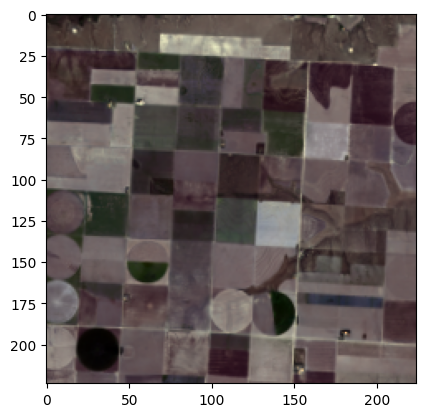

In [191]:
image_rgb = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)

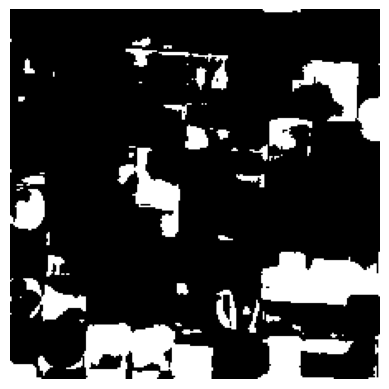

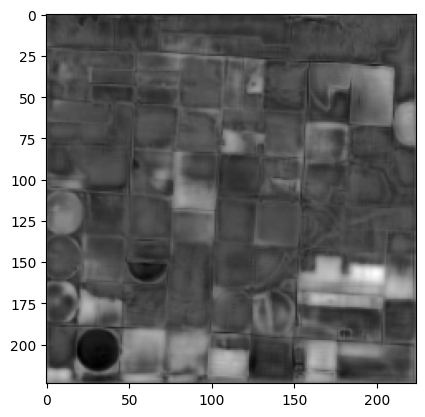

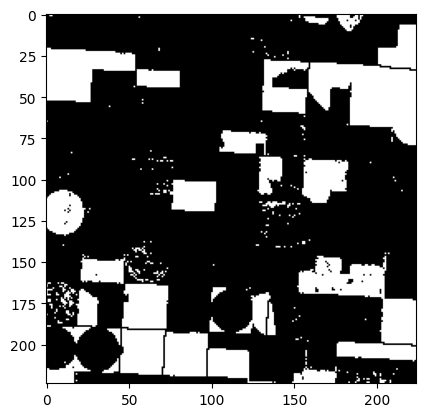

In [192]:
import random

test_img = image1[0].unsqueeze(0).to("cuda")
grd_truth_image = image1[1]
# tensor_with_batch = tensor
pred = model(test_img)

import matplotlib.pyplot as plt
import torch.nn.functional as F

# Assuming pred[0] is your prediction tensor with shape (height, width, num_classes)
# Convert pred[0] to a PyTorch tensor
pred_tensor = pred[0].cpu().detach()

# Apply softmax along the channel dimension
probs = F.softmax(pred_tensor, dim=0)

# Get the probability values for class 0 and class 1
prob_class_0 = probs[0]
prob_class_1 = probs[1]



# Threshold for class 1
threshold = 0.51

# Create a mask based on the probabilities
segmentation_mask = torch.where(prob_class_1 >= threshold, torch.tensor(1), torch.tensor(0))

tensor_numpy = segmentation_mask.numpy()  # Convert the detached tensor to a NumPy array

# Plot the tensor using imshow
plt.imshow(tensor_numpy, cmap='gray')  # Assuming the tensor represents a grayscale image
plt.axis('off')  # Turn off axis
plt.show()

plt.imshow(pred[0][1].detach().cpu().numpy(), cmap="gray")
plt.show()

plt.imshow(grd_truth_image, cmap="gray")
plt.show()


In [413]:
prob_class_1_1=prob_class_1.flatten()

(array([23136.,   645.,   426.,   353.,   291.,   315.,   400.,   402.,
          722., 23486.]),
 array([1.66231341e-13, 1.00000001e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

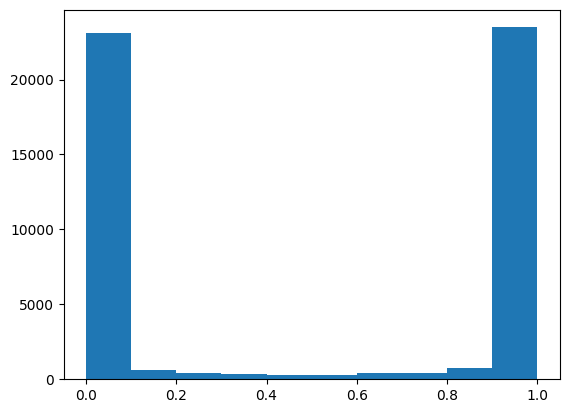

In [258]:
plt.hist(prob_class_1_1)

In [242]:
import torch

def threshold_predictions(predicted_image, threshold=0.5):
    """
    Apply thresholding to predicted image to convert it to binary mask.

    Args:
        predicted_image (torch.Tensor): Predicted image tensor of shape (1, C, H, W).
        threshold (float): Threshold value for binarization (default is 0.5).

    Returns:
        torch.Tensor: Binary mask tensor of shape (1, H, W).
    """
    # Apply softmax along the channel dimension to get probabilities
    probabilities = torch.softmax(predicted_image, dim=1)

    # Extract probabilities for the foreground class (class 1)
    foreground_probabilities = probabilities[:, 1, :, :]

    # Apply thresholding to the probabilities
    binary_mask = (foreground_probabilities > threshold).float()

    return binary_mask

# Example usage
# Assuming `predicted_image` is your torch tensor of shape (1, C, H, W)
# predicted_image = torch.randn(1, C, H, W)  # Example tensor, replace it with your predicted image

# Apply thresholding
binary_mask = threshold_predictions(pred)

# Print shape of the resulting binary mask
print("Shape of binary mask:", binary_mask.shape)


Shape of binary mask: torch.Size([1, 224, 224])


In [108]:
# STEP 5
# Same model parameters
compiled_model.save(save_object="params")

Save location: /shishir/multi-temporal-crop-classification-baseline/output6/Unet_ep10/chkpt
--------------------- Model parameters is saved to disk ---------------------


In [111]:
compiled_model.load_params(dir_params="/shishir/multi-temporal-crop-classification-baseline/output6/Unet_ep30/chkpt/Unet_final_state.pth",freeze_params=True)

[autoreload of model_compiler failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/shishir/multi-temporal-crop-classification-baseline/src/model_compiler.py", line 239
    print("Parameters frozen")             
                                

AttributeError: 'NoneType' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

---------------- Start evaluation ----------------


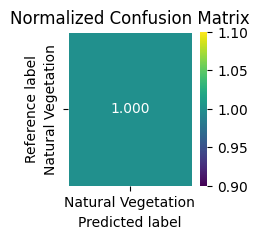

---------------- Evaluation finished in 4s ----------------


In [392]:
# STEP 6
# Generate the accuracy metrics.
metrics = compiled_model.accuracy_evaluation(val_loader, filename=config["val_metric_fname"])

In [217]:
import csv
import itertools
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns


class Evaluator(object):
    
    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)


    def overall_accuracy(self):
        acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return acc


    def classwise_overal_accuracy(self):
        acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        return acc


    def precision(self):
        """
        Also known as User’s Accuracy (UA) and Positive Prediction Value (PPV).
        """
        tp = np.diag(self.confusion_matrix)
        fp = np.sum(self.confusion_matrix, axis=0) - tp
        precision = np.where((tp + fp) != 0,
                             tp / (tp + fp),
                             0)
        return precision


    def recall(self):
        """
        Also known as Producer's Accuracy (PA), True Positive Rate, Sensitivity 
        and hit rate.
        """
        tp = np.diag(self.confusion_matrix)
        fn = np.sum(self.confusion_matrix, axis=1) - tp
        recall = np.where((tp + fn) != 0,
                          tp / (tp + fn),
                          0)
        return recall
    
    def f1_score(self):
        """
        Also known as balanced F-score or F-measure.

        The F1 score can be interpreted as a weighted average of the precision and 
        recall, where an F1 score reaches its best value at 1 and worst score at 0.
        """
        precision = self.precision()
        recall = self.recall()
        f1_score = np.where((precision + recall) != 0, 
                        2 * (precision * recall) / (precision + recall), 
                        0)
        return f1_score


    def intersection_over_union(self):
        tp = np.diag(self.confusion_matrix)
        # Predicted Positive (TP+FP); each column's sum
        fp = np.sum(self.confusion_matrix, axis=0) - tp
        # Actual Positive (TP+FN); each row's sum
        fn = np.sum(self.confusion_matrix, axis=1) - tp
        iou = np.where((tp + fp + fn) != 0,
                       tp / (tp + fp + fn),
                       0)
        return iou


    def _generate_matrix(self, ref_img, pred_img):
        """
        Generate confusion matrix for a given pair of ground truth and predicted
        images within a batch.

        For each pair in the batch, the resulting confusion matrix is a 2D array 
        where each row corresponds to a class in the ground truth, and each column 
        corresponds to a class in the prediction. The (i, j) element of the matrix 
        is the number of pixels that belong to class i in the ground truth and are 
        classified as class j in the prediction.

        Args:
            ref_img (np.array): 2D array of ref annotation.
            pred_img (np.array): 2D array of model's prediction.

        Returns:
            np.array: A 2D confusion matrix of size (num_class x num_class). 
                      Rows correspond to the true classes and columns correspond 
                      to the predicted classes.
        """
        mask = (ref_img >= 0) & (ref_img < self.num_class)
        label = self.num_class * ref_img[mask].astype('int') + pred_img[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix


    def add_batch(self, ref_img, pred_img):
        """
        update the cumulative confusion matrix with the results from a 
        new batch of images.
        """
        assert ref_img.shape == pred_img.shape
        batch_size = ref_img.shape[0]
        for i in range(batch_size):
            self.confusion_matrix += self._generate_matrix(ref_img[i], 
                                                           pred_img[i])

    def plot_confusion_matrix(self, class_mapping, save_path="confusion_matrix.png"):
        # Remove the first row and column
        conf_mat_without_unknown = self.confusion_matrix[1:, 1:]
        
        # Normalize the confusion matrix by row (i.e., by the true class)
        row_sums = conf_mat_without_unknown.sum(axis=1, keepdims=True)
        conf_mat_normalized = np.divide(conf_mat_without_unknown, row_sums, where=row_sums!=0)
        
        classes = [class_mapping[i] for i in range(1, self.num_class)]

        # Create a dataframe for the seaborn heatmap
        df_cm = pd.DataFrame(conf_mat_normalized,
                            index = classes, 
                            columns = classes)
    
        # Create the figure
        plt.figure(figsize=(self.num_class, self.num_class))
    
        # Use seaborn to plot the heatmap
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".3f", cmap='viridis', linewidths=.5, cbar=True)
    
        # Set the title and labels
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('Reference label')
    
        # Save the figure
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
        plt.show()


    def reset(self):
        """
        Resets the confusion matrix.

        This function sets the confusion matrix back to an empty state, ready to 
        start a new round of evaluation. It can be useful in cases where evaluation 
        is done in an episodic manner, such as when evaluating model performance after
        each epoch during training.
        """
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

In [417]:
def do_accuracy_evaluation(model, dataloader, num_classes, class_mapping, out_name=None):
    """
    Evaluate the performance of a trained model on a dataset and calculate various metrics.
    
    Args:
        model (torch.nn.Module): The trained model to be evaluated.
        dataloader (torch.utils.data.DataLoader): The dataloader for the evaluation dataset.
        num_classes (int): The number of target classes in the dataset.
        class_mapping (dict): A dictionary mapping class indices to class names.
        out_name (str, optional): The path where the evaluation metrics are to be saved. If None, 
            metrics are not saved. Defaults to None.
    
    Returns:
        dict: A dictionary containing the calculated metrics including Overall Accuracy, 
            Mean Accuracy, Mean IoU (Intersection over Union), mean Precision, and mean Recall.
            
    Notes:
        The function calculates confusion matrix and plots it using seaborn. If out_name is provided, 
        it also saves the overall and per-class metrics into CSV files.
    """
    evaluator = Evaluator(num_classes)
    print(evaluator.confusion_matrix)

    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            if torch.isnan(outputs).any():
                print("NaN value found in model outputs!")
            outputs = F.softmax(outputs, 1)
            _, preds = torch.max(outputs.data, 1)

            # add batch to evaluator
            evaluator.add_batch(labels.cpu().numpy(), 
                                preds.cpu().numpy())

    # calculate evaluation metrics
    overall_accuracy = evaluator.overall_accuracy()
    classwise_overal_accuracy = evaluator.classwise_overal_accuracy()
    
    mean_accuracy = np.nanmean(classwise_overal_accuracy)
    IoU = evaluator.intersection_over_union()
    
    mean_IoU = np.nanmean(IoU)
    precision = evaluator.precision()
    mean_precision = np.nanmean(precision)
    recall = evaluator.recall()
    mean_recall = np.nanmean(recall)
    f1_score = evaluator.f1_score()
    mean_f1_score = np.nanmean(f1_score)

    metrics = {
        "Overall Accuracy": overall_accuracy,
        "Mean Accuracy": mean_accuracy,
        "Mean IoU": mean_IoU,
        "mean Precision": mean_precision,
        "mean Recall": mean_recall,
        "Mean F1 Score": mean_f1_score,
        "classwise_overal_accuracy" :classwise_overal_accuracy,
        "IoU":IoU
    }

    # print confusion matrix
    evaluator.plot_confusion_matrix(class_mapping)
    
    if out_name:
        with open(out_name, mode="w", newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Metric", "Value"])

            for metric_name, metric_value in metrics.items():
                writer.writerow([metric_name, metric_value])
        
        class_metrics_out_name = out_name.rsplit(".", 1)[0] + "_classwise." + out_name.rsplit(".", 1)[1]
        with open(class_metrics_out_name, mode="w", newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Class", "Accuracy", "IoU", "Precision", "Recall", "F1 Score"])

            for i in range(1, evaluator.num_class):
                class_name = class_mapping[i]
                writer.writerow([class_name, classwise_overal_accuracy[i], IoU[i], 
                                 precision[i], recall[i], f1_score[i]])
    
    return metrics

[[0. 0.]
 [0. 0.]]


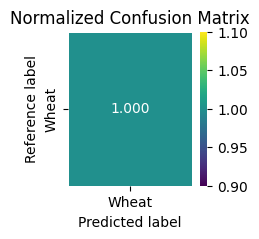

{'Overall Accuracy': 0.9391500599561569,
 'Mean Accuracy': 0.8920673479927124,
 'Mean IoU': 0.7768044201864994,
 'mean Precision': 0.8439736390011168,
 'mean Recall': 0.8920673479927124,
 'Mean F1 Score': 0.8656845908939148,
 'classwise_overal_accuracy': array([0.95405382, 0.83008088]),
 'IoU': array([0.93240469, 0.62120415])}

In [418]:
do_accuracy_evaluation(model, train_loader, 2, {0:"background",1:"Wheat"}, None)


### Steps for prediction

In [386]:
test_dataset = CropData(src_dir=config["src_dir"],
                       usage="inference",
                       dataset_name="",
                       csv_path=config["test_csv_path"],
                       apply_normalization=config["apply_normalization"],
                       normal_strategy=config["normal_strategy"],
                       stat_procedure=config["stat_procedure"],
                       global_stats=config["global_stats"],)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [00:15<00:00, 48.53it/s]

------ inference dataset with 771 patches created ------


In [388]:
def meta_handling_collate_fn(batch):
    images = []
    labels = []
    img_ids = []
    img_metas = []

    # Unpack elements from each sample in the batch
    for sample in batch:
        images.append(sample[0])
        labels.append(sample[1])
        img_ids.append(sample[2])
        img_metas.append(sample[3])  # append the dict to the list

    # Stack images and labels into a single tensor
    images = torch.stack(images, dim=0)
    labels = torch.stack(labels, dim=0)
    
    return images, labels, img_ids, img_metas


test_loader = DataLoader(test_dataset, 
                        batch_size=config["val_test_BatchSize"], 
                        shuffle=False,
                        collate_fn=meta_handling_collate_fn)

In [ ]:
model = Unet(n_classes=config["n_classes"], 
             in_channels=config["input_channels"], 
             use_skipAtt=config["use_skipAtt"],
             filter_config=config["filter_config"],
             dropout_rate=config["train_dropout_rate"])

In [ ]:
compiled_model = ModelCompiler(model,
                               working_dir=config["working_dir"],
                               out_dir=config["out_dir"],
                               num_classes=config["n_classes"],
                               inch=config["input_channels"],
                               class_mapping=config["class_mapping"],
                               gpu_devices=config["gpuDevices"],
                               model_init_type=config["init_type"], 
                               params_init=config["params_init"],
                               freeze_params=config["freeze_params"])

In [389]:
compiled_model.inference(test_loader, out_dir=config["out_dir"])

---------------- Start prediction ----------------
Pred tile: 002_060 is written to output6
Pred tile: 009_061 is written to output6
Pred tile: 024_087 is written to output6
Pred tile: 033_196 is written to output6
Pred tile: 034_112 is written to output6
Pred tile: 034_146 is written to output6
Pred tile: 034_147 is written to output6
Pred tile: 039_109 is written to output6
Pred tile: 045_106 is written to output6
Pred tile: 046_088 is written to output6
Pred tile: 049_232 is written to output6
Pred tile: 050_168 is written to output6
Pred tile: 051_176 is written to output6
Pred tile: 052_043 is written to output6
Pred tile: 052_076 is written to output6
Pred tile: 052_247 is written to output6
Pred tile: 053_113 is written to output6
Pred tile: 054_201 is written to output6
Pred tile: 057_087 is written to output6
Pred tile: 057_195 is written to output6
Pred tile: 059_082 is written to output6
Pred tile: 059_259 is written to output6
Pred tile: 060_086 is written to output6
Pred t

KeyboardInterrupt: 

In [390]:
config["out_dir"]

'output6'

In [391]:
model

DataParallel(
  (module): Unet(
    (encoder_1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(18, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Dropout(p=0.15, inplace=False)
      )
    )
    (encoder_2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0, affine=Tru

In [368]:
l1=[1,3,2]

In [371]:
l=l1[1:]

In [372]:
l.sort()

In [373]:
l

[2, 3]